# 作业说明：
**✓代码跑通**

请大家根据课上所学内容，在 VGGNet类中补全代码，构造VGG网络，保证程序跑通。在VGG构造成功的基础上，可尝试构造其他网络。

**✓调优**

思考并动手进行调优，以在验证集上的准确率为评价指标，验证集上准确率越高，得分越高！



**任务描述：**

口罩识别，是指可以有效检测在密集人流区域中携带和未携戴口罩的所有人脸，同时判断该者是否佩戴口罩。通常由两个功能单元组成，可以分别完成口罩人脸的检测和口罩人脸的分类。

**本次实践相比生产环境中口罩识别的问题，降低了难度，仅实现人脸口罩判断模型，可实现对人脸是否佩戴口罩的判定**。本实践旨在通过一个口罩识别的案列，让大家理解和掌握如何使用飞桨动态图搭建一个经典的卷积神经网络

**特别提示：本实践所用数据集均来自互联网，请勿用于商务用途。**

In [1]:
import os
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
from PIL import ImageEnhance
import paddle.fluid as fluid
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
from paddle.fluid.dygraph import CosineDecay, Conv2D, Pool2D,Sequential,BatchNorm,Linear
from paddle.fluid import  layers

In [2]:
'''
参数配置
'''
BATCH_SIZE = 8
train_parameters = {
    "input_size": [3, 224, 224],                              #输入图片的shape
    "class_dim": 2,                                          #分类数
    "src_path":"/home/aistudio/work/maskDetect.zip",#原始数据集路径
    "target_path":"/home/aistudio/data/",                     #要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",       #train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",         #eval.txt路径
    "readme_path": "/home/aistudio/data/readme.json",         #readme.json路径
    "label_dict":{},                                          #标签字典
    "num_epochs": 60,                                         #训练轮数
    "train_batch_size": BATCH_SIZE,                                    #训练时每个批次的大小
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.1 * (BATCH_SIZE / 256)                                           #超参数学习率
    } 
}

# **一、数据准备**

（1）解压原始数据集

（2）按照比例划分训练集与验证集

（3）乱序，生成数据列表

（4）构造训练数据集提供器和验证数据集提供器

In [3]:

def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至data目录下
    '''
    if(not os.path.isdir(target_path + "maskDetect")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()

In [4]:

def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    #存放所有类别的信息
    class_detail = []
    #获取所有类别保存的文件夹名称
    data_list_path=target_path+"maskDetect/"
    class_dirs = os.listdir(data_list_path)  
    #总的图像数量
    all_class_images = 0
    #存放类别标签
    class_label=0
    #存放类别数目
    class_dim = 0
    #存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    #读取每个类别，['maskimages', 'nomaskimages']
    for class_dir in class_dirs:
        if class_dir != ".DS_Store":
            class_dim += 1
            #每个类别的信息
            class_detail_list = {}
            eval_sum = 0
            trainer_sum = 0
            #统计每个类别有多少张图片
            class_sum = 0
            #获取类别路径 
            path = data_list_path  + class_dir
            # 获取所有图片
            img_paths = os.listdir(path)
            for img_path in img_paths:                                  # 遍历文件夹下的每个图片
                name_path = path + '/' + img_path                       # 每张图片的路径
                if class_sum % 10 == 0:                                 # 每10张图片取一个做验证数据
                    eval_sum += 1                                       # test_sum为测试数据的数目
                    eval_list.append(name_path + "\t%d" % class_label + "\n")
                else:
                    trainer_sum += 1 
                    trainer_list.append(name_path + "\t%d" % class_label + "\n")#trainer_sum测试数据的数目
                class_sum += 1                                          #每类图片的数目
                all_class_images += 1                                   #所有类图片的数目
             
            # 说明的json文件的class_detail数据
            class_detail_list['class_name'] = class_dir             #类别名称，如jiangwen
            class_detail_list['class_label'] = class_label          #类别标签
            class_detail_list['class_eval_images'] = eval_sum       #该类数据的测试集数目
            class_detail_list['class_trainer_images'] = trainer_sum #该类数据的训练集数目
            class_detail.append(class_detail_list)  
            #初始化标签列表
            train_parameters['label_dict'][str(class_label)] = class_dir
            class_label += 1 
            
    #初始化分类数
    train_parameters['class_dim'] = class_dim

   
    
    #乱序  
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f2:
        for train_image in trainer_list:
            f2.write(train_image) 

    # 说明的json文件信息
    readjson = {}
    readjson['all_class_name'] = data_list_path                  #文件父目录
    readjson['all_class_images'] = all_class_images
    readjson['class_detail'] = class_detail
    jsons = json.dumps(readjson, sort_keys=True, indent=4, separators=(',', ': '))
    with open(train_parameters['readme_path'],'w') as f:
        f.write(jsons)
    print ('生成数据列表完成！')

In [5]:
def ricap(X, y):
    '''
        功能：图像增强，Random Image Cropping and Patching
        参数：
            X：batch imgs
            y: batch labels
        超参：
            beta: beta分布的alpha和beta参数，这个可以自己设置，并观察结果
        引用：
            Data Augmentation using Random Image Cropping and Patching for Deep CNNs(https://arxiv.org/abs/1811.09030v1)
    '''
    beta = 0.1
    I_x, I_y = X.shape[2:]
    w = int(np.round(I_x * np.random.beta(beta, beta)))
    h = int(np.round(I_y * np.random.beta(beta, beta)))
    w_ = [w, I_x - w, w, I_x - w]
    h_ = [h, h, I_y - h, I_y - h]
    cropped_images = {}
    c_ = {}
    W_ = {}
    for k in range(4):
        index = np.arange(X.shape[0])
        np.random.shuffle(index)
        x_k = np.random.randint(0, I_x - w_[k] + 1)
        y_k = np.random.randint(0, I_y - h_[k] + 1)
        cropped_images[k] = X[index][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
        c_[k] = y[index]
        W_[k] = w_[k] * h_[k] / (I_x * I_y)
    patched_images = np.concatenate(
        (np.concatenate((cropped_images[0], cropped_images[1]), 2),
        np.concatenate((cropped_images[2], cropped_images[3]), 2)), 3)
    return patched_images, y, W_, c_

def mixup(X, y):
    '''
        功能：图像增强，mixup
        参数：
            X：batch imgs
            y: batch labels
        超参：
            beta: beta分布的alpha和beta参数，这个可以自己设置，并观察结果
        引用：
            mixup: Beyond Empirical Risk Minimization(https://arxiv.org/abs/1710.09412)
    '''
    mixup_alpha = 0.1
    seed = np.random.beta(mixup_alpha, mixup_alpha)
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    images_a, images_b = X, X[index]
    labels_a, labels_b = y, y[index]
    mixed_images = seed * images_a + (1 - seed) * images_b
    return mixed_images, labels_a, labels_b, seed

def custom_reader(file_list):
    '''
    自定义reader
    '''
    def reader():
        with open(file_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                img_path, lab = line.strip().split('\t')
                img = Image.open(img_path) 
                if img.mode != 'RGB': 
                    img = img.convert('RGB') 
                size = train_parameters['input_size'][-1]
                img = img.resize((size, size), Image.BILINEAR)
                img = np.array(img).astype('float32') 
                img = img.transpose((2, 0, 1))  # HWC to CHW 
                img = img/255                # 像素值归一化 
                yield img, int(lab) 
    return reader


In [6]:
'''
参数初始化
'''
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']

'''
解压原始数据到指定路径
'''
unzip_data(src_path,target_path)

'''
划分训练集与验证集，乱序，生成数据列表
'''
#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

'''
构造数据提供器
'''
train_reader = paddle.batch(custom_reader(train_list_path),
                            batch_size=batch_size,
                            drop_last=True)
eval_reader = paddle.batch(custom_reader(eval_list_path),
                            batch_size=batch_size,
                            drop_last=True)


生成数据列表完成！


In [7]:
data = next(train_reader())
data[0][0].shape, data[0][1]

((3, 224, 224), 1)

# **二、模型配置**

![](https://ai-studio-static-online.cdn.bcebos.com/9ca0744272b0449186f766afcabadd598e24679088a4438dafede05a71b7c141)

VGG的核心是五组卷积操作，每两组之间做Max-Pooling空间降维。同一组内采用多次连续的3X3卷积，卷积核的数目由较浅组的64增多到最深组的512，同一组内的卷积核数目是一样的。卷积之后接两层全连接层，之后是分类层。由于每组内卷积层的不同，有11、13、16、19层这几种模型，上图展示一个16层的网络结构。



In [8]:
class ConvPool(fluid.dygraph.Layer):
    '''卷积+池化'''
    def __init__(self,
                 num_channels,
                 num_filters,
                 filter_size,
                 pool_size,
                 pool_stride,
                 groups,
                 pool_padding=0,
                 pool_type='max',
                 conv_stride=1,
                 conv_padding=0,
                 act=None):
        super(ConvPool, self).__init__()  

        self._conv2d_list = []

        for i in range(groups):
            conv2d = self.add_sublayer(   #返回一个由所有子层组成的列表。
                'bb_%d' % i,
                fluid.dygraph.Conv2D(
                num_channels=num_channels, #通道数
                num_filters=num_filters,   #卷积核个数
                filter_size=filter_size,   #卷积核大小
                stride=conv_stride,        #步长
                padding=conv_padding,      #padding大小，默认为0
                act=act)
            )
            # num_channels = num_filters
        self._conv2d_list.append(conv2d)   

        self._pool2d = fluid.dygraph.Pool2D(
            pool_size=pool_size,           #池化核大小
            pool_type=pool_type,           #池化类型，默认是最大池化
            pool_stride=pool_stride,       #池化步长
            pool_padding=pool_padding      #填充大小
            )

    def forward(self, inputs):
        x = inputs
        for conv in self._conv2d_list:
            x = conv(x)
        x = self._pool2d(x)
        # print(x.shape)
        return x




# ###请在以下cell中完成VGG网络的定义###

In [9]:

# in_chs, out_chs, groups
conv_arch = [(3, 64, 2), (64, 128, 2), (128, 256, 3), (256, 512, 3), (512, 512, 3)]
class VGGNet(fluid.dygraph.Layer):
    '''
    VGG网络
    '''
    def __init__(self, * , channels, fig_size, num_classes):
        super(VGGNet, self).__init__()
        convs = []
        for arch in conv_arch:
            (in_chs, out_chs, groups) = arch
            convs.append(
                ConvPool(
                    num_channels = in_chs, 
                    num_filters = out_chs, 
                    filter_size = 3, 
                    pool_size = 2, 
                    pool_stride = 2, 
                    groups = groups, 
                    pool_padding = 0,
                    pool_type = 'max',
                    conv_stride = 1,
                    conv_padding = 1,
                    act = 'relu'
                ))
            # convs.append(fluid.dygraph.BatchNorm(out_chs))
        self.vgg_conv = fluid.dygraph.Sequential(*convs)
        out_chs, fig_size = conv_arch[-1][1], fig_size // (2**len(conv_arch))
        self.fc1 = fluid.dygraph.Linear(out_chs * fig_size * fig_size, 4096, act='relu')
        self.fc2 = fluid.dygraph.Linear(4096, 4096, act='relu')
        self.fc3 = fluid.dygraph.Linear(4096, num_classes, act='softmax')
        
        

    def forward(self, inputs):
        """前向计算"""
        # vgg conv
        conv_feature = self.vgg_conv(inputs)
        fc_feature = self.fc1(fluid.layers.flatten(conv_feature))
        fc_feature = self.fc2(fc_feature)
        y = self.fc3(fc_feature)
        # acc = fluid.layers.accuracy(y, label)
        return y

## resnet18

In [10]:
# #ResNet18
# class Residual(fluid.dygraph.Layer):
#     #可以设定输出通道数、是否使用额外的1x1卷积层来修改通道数以及卷积层的步幅。
#     def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
#         super(Residual, self).__init__()
#         self.conv1 = Conv2D(in_channels, out_channels, 3, padding=1, stride=stride)
#         self.conv2 = Conv2D(out_channels, out_channels, 3, padding=1)
#         if use_1x1conv:
#             self.conv3 = Conv2D(in_channels, out_channels, 1, stride=stride)
#         else:
#             self.conv3 = None
#         self.bn1 = BatchNorm(out_channels, act='relu')
#         self.bn2 = BatchNorm(out_channels)

#     def forward(self, X):
#         # Y = layers.relu(self.conv1(X))
#         # Y = self.conv2(Y)
#         Y = self.bn1(self.conv1(X))
#         Y = self.bn2(self.conv2(Y))
#         if self.conv3:
#             X = self.conv3(X)
#         return layers.relu(Y + X)

# class ResBlock(fluid.dygraph.Layer):
#     def __init__(self, in_channels, out_channels, num_rediduals, first_block=False):
#         super(ResBlock, self).__init__()
#         if first_block:
#             assert in_channels == out_channels # 第一个模块的通道数同输入通道数一致
#         block = []
#         for i in range(num_rediduals):
#             block.append(Residual(in_channels, out_channels, use_1x1conv=not first_block, stride=2-int(first_block)))
#             in_channels = out_channels
#         self.resi_block = Sequential(*block)

#     def forward(self, X):
#         return self.resi_block(X)

# class ResNet(fluid.dygraph.Layer):
#     def __init__(self, *, channels, fig_size, num_class):
#         super(ResNet, self).__init__()
#         self.conv = Sequential(
#             Conv2D(channels, 32, 7, 2, 3, act='relu'),
#             BatchNorm(32, act='relu'),
#         )
#         self.res_block_arch = [(32, 32, 2, True), (32, 64, 2), (64, 128, 2), (128, 256, 2)]
#         self.res_blocks = Sequential()
#         for i, arch in enumerate(self.res_block_arch):
#             self.res_blocks.add_sublayer(f'res_block_{i+1}', ResBlock(*arch))
#         self.global_avg_pool = Pool2D(pool_type='avg',global_pooling=True)
#         self.fc =Linear(256, num_class, act='softmax')

#     def forward(self, X):
#         conv_features = layers.pool2d(self.conv(X),2,'max',2)
#         res_features = self.res_blocks(conv_features)
#         global_avg_pool = self.global_avg_pool(res_features)
#         global_avg_pool = layers.flatten(global_avg_pool)
#         y = self.fc(global_avg_pool)
#         return y

# **三、模型训练 && 四、模型评估**

In [11]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()


def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

2
{'0': 'nomaskimages', '1': 'maskimages'}
train_pass:0,train_loss:[2.2630959],train_acc:[0.62499994]
train_pass:1,train_loss:[0.5549518],train_acc:[0.7281463]
train_pass:2,train_loss:[0.5026201],train_acc:[0.78125054]
train_pass:3,train_loss:[0.47665977],train_acc:[0.78675115]
train_pass:4,train_loss:[0.4086338],train_acc:[0.8310369]
train_pass:5,train_loss:[0.36519033],train_acc:[0.86737645]
train_pass:6,train_loss:[0.33260715],train_acc:[0.8792175]
train_pass:7,train_loss:[0.3956714],train_acc:[0.8447345]
train_pass:8,train_loss:[0.2993569],train_acc:[0.90317136]
train_pass:9,train_loss:[0.29661095],train_acc:[0.9087391]
train_pass:10,train_loss:[0.21587846],train_acc:[0.9522193]
train_pass:11,train_loss:[0.23687105],train_acc:[0.9225666]
train_pass:12,train_loss:[0.19809166],train_acc:[0.9433671]
train_pass:13,train_loss:[0.19605683],train_acc:[0.94166124]
train_pass:14,train_loss:[0.17333575],train_acc:[0.94660723]
train_pass:15,train_loss:[0.1211123],train_acc:[0.9845753]
train_p

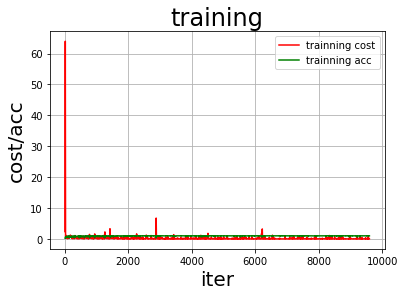

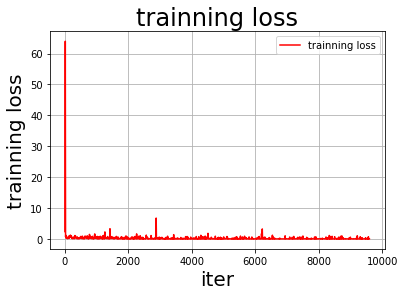

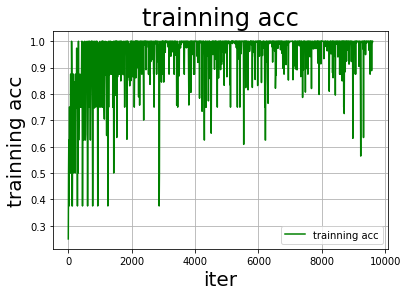

Final loss: [0.02057265]


In [12]:
'''
模型训练
'''
#with fluid.dygraph.guard(place = fluid.CUDAPlace(0)):
train_losses = []
train_accs = []
with fluid.dygraph.guard():
    print(train_parameters['class_dim'])
    print(train_parameters['label_dict'])
    vgg = VGGNet(channels=3, fig_size=train_parameters['input_size'][-1], num_classes=2)
    vgg.train()

    # resnet = ResNet(channels=3, fig_size=train_parameters['input_size'][-1], num_class=2)
    # resnet.train()

    # optimizer=fluid.optimizer.AdamOptimizer(learning_rate=train_parameters['learning_strategy']['lr'],parameter_list=vgg.parameters()) 
    optimizer=fluid.optimizer.SGDOptimizer(
        CosineDecay(train_parameters['learning_strategy']['lr'], train_parameters['num_epochs'], train_parameters['num_epochs']),
        parameter_list=vgg.parameters())
    # optimizer=fluid.optimizer.SGDOptimizer(
    #     CosineDecay(train_parameters['learning_strategy']['lr'], train_parameters['num_epochs'], train_parameters['num_epochs']),
    #     parameter_list=resnet.parameters())
    for epoch_num in range(train_parameters['num_epochs']):
        n = 0
        L = 0
        accuracy = 0
        for batch_id, data in enumerate(train_reader()):
            images = np.array([x[0] for x in data]).astype('float32')           
            labels = np.array([x[1] for x in data]).astype('int64')      

            # images, labels, W_, c_ = ricap(images, labels)  # ricap data aug
            images, labels_a, labels_b, seed = mixup(images, labels)

            labels = labels[:, np.newaxis]

            #将Numpy转换为DyGraph接收的输入
            img = fluid.dygraph.to_variable(images)
            label = fluid.dygraph.to_variable(labels)

            out = vgg(img)
            # out = resnet(img)

            # loss = fluid.layers.cross_entropy(out, label)
            # loss = fluid.layers.sum([W_[k] * fluid.layers.cross_entropy(out, fluid.layers.unsqueeze(fluid.dygraph.to_variable(c_[k]),[1])) for k in range(4)])  # ricap loss
            loss = seed * fluid.layers.cross_entropy(out, fluid.dygraph.to_variable(labels_a)) + (1 - seed) * fluid.layers.cross_entropy(out, fluid.dygraph.to_variable(labels_b))
            avg_loss = fluid.layers.mean(loss)

            # acc = fluid.layers.accuracy(out, label)
            # acc = fluid.layers.sum([W_[k] * fluid.layers.accuracy(out, fluid.layers.unsqueeze(fluid.dygraph.to_variable(c_[k]),[1])) for k in range(4)]) # ricap acc
            acc = seed * fluid.layers.accuracy(out, layers.unsqueeze(fluid.dygraph.to_variable(labels_a), axes=[1])) + (1 - seed) * fluid.layers.accuracy(out, layers.unsqueeze(fluid.dygraph.to_variable(labels_b),axes=[1]))

            #使用backward()方法可以执行反向网络
            avg_loss.backward()
            optimizer.minimize(avg_loss)
             
            #将参数梯度清零以保证下一轮训练的正确性
            vgg.clear_gradients()
            # resnet.clear_gradients()
            

            all_train_iter=all_train_iter+train_parameters['train_batch_size']
            all_train_iters.append(all_train_iter)
            all_train_costs.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0])
                
            # if batch_id % 1 == 0:
            #     print("Loss at epoch {} step {}: {}, acc: {}".format(epoch_num, batch_id, avg_loss.numpy(), acc.numpy()))
            n += 1
            L += avg_loss.numpy()
            accuracy += acc.numpy()

        print("train_pass:{},train_loss:{},train_acc:{}".format(epoch_num,L/n,accuracy / n))
        train_losses.append(L/n)
        train_accs.append(accuracy/n) 
    draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")  
    draw_process("trainning loss","red",all_train_iters,all_train_costs,"trainning loss")
    draw_process("trainning acc","green",all_train_iters,all_train_accs,"trainning acc")  
    
    #保存模型参数
    fluid.save_dygraph(vgg.state_dict(), "vgg")   
    # fluid.save_dygraph(resnet.state_dict(), "resnet") 
    print("Final loss: {}".format(avg_loss.numpy()))


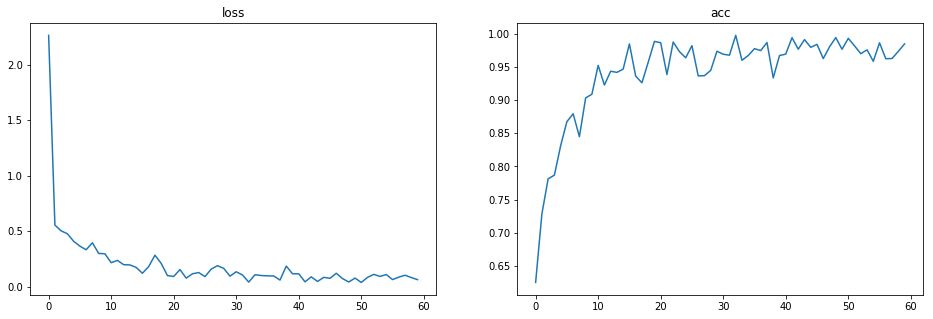

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(train_losses)
plt.title('loss')
plt.subplot(122)
plt.plot(train_accs)
plt.title('acc')
plt.savefig('vgg_mixup.png')
plt.show()

## 结果展示



| model | data aug | acc |
| -------- | -------- | -------- |
| vgg16     | None     |  1.0    |
| resnet18     | None     |  0.875    |
| vgg16     | RICAP     |   0.9375   |
| resnet18     | RICAP     |  0.875    |
| vgg16     | MIXUP     |   1.0   |
| resnet18     | MIXUP     |  0.875    |

> resnet没调好

### 1. vgg16
![](./vgg16.png)

### 2. vgg16 + ricap
![](./vgg16_ricap.png)

### 3.vgg16 + mixup
![](./vgg16_mixup.png)

In [14]:
'''
模型校验
'''
with fluid.dygraph.guard():
    model, _ = fluid.load_dygraph("vgg")
    vgg = VGGNet(channels=3, fig_size=train_parameters['input_size'][-1], num_classes=2)
    # model, _ = fluid.load_dygraph('resnet')
    # resnet = ResNet(channels=3, fig_size=train_parameters['input_size'][-1], num_class=2)
    vgg.load_dict(model)
    vgg.eval()

    # resnet.load_dict(model)
    # resnet.eval()

    accs = []
    for batch_id, data in enumerate(eval_reader()):
        dy_x_data = np.array([x[0] for x in data]).astype('float32')
        y_data = np.array([x[1] for x in data]).astype('int')
        y_data = y_data[:, np.newaxis]
        
        img = fluid.dygraph.to_variable(dy_x_data)
        label = fluid.dygraph.to_variable(y_data)

        out = vgg(img)
        # out = resnet(img)
        
        acc = fluid.layers.accuracy(out, label)
        print(f'current test batch acc:{acc.numpy()}')
        # acc = fluid.layers.accuracy(out, label)
        lab = np.argsort(out.numpy())
        accs.append(acc.numpy()[0])
print(np.mean(accs))

current test batch acc:[1.]
current test batch acc:[1.]
1.0


# **五、模型预测**

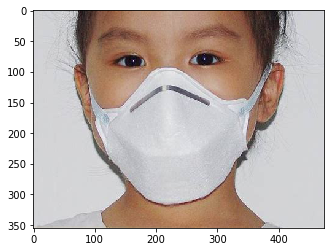

第1个样本,被预测为：maskimages
结束


In [16]:
def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((224, 224), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                # 像素值归一化 
    return img

label_dic = train_parameters['label_dict']

'''
模型预测
'''
with fluid.dygraph.guard():
    model, _ = fluid.dygraph.load_dygraph("vgg")
    # model, _ = fluid.dygraph.load_dygraph("resnet")
    vgg = VGGNet(channels=3, fig_size=train_parameters['input_size'][-1], num_classes=2)
    # resnet = ResNet(channels=3, fig_size=train_parameters['input_size'][-1], num_class=2)
    vgg.load_dict(model)
    vgg.eval()

    # resnet.load_dict(model)
    # resnet.eval()
    
    #展示预测图片
    infer_path='/home/aistudio/data/data23615/infer_mask01.jpg'
    img = Image.open(infer_path)
    plt.imshow(img)          #根据数组绘制图像
    plt.show()               #显示图像

    #对预测图片进行预处理
    infer_imgs = []
    infer_imgs.append(load_image(infer_path))
    infer_imgs = np.array(infer_imgs)
   
    for  i in range(len(infer_imgs)):
        data = infer_imgs[i]
        dy_x_data = np.array(data).astype('float32')
        dy_x_data=dy_x_data[np.newaxis,:, : ,:]
        img = fluid.dygraph.to_variable(dy_x_data)
        out = vgg(img)
        # out = resnet(img)
        lab = np.argmax(out.numpy())  #argmax():返回最大数的索引
        print("第{}个样本,被预测为：{}".format(i+1,label_dic[str(lab)]))
        
print("结束")
